In [10]:
import pandas as pd
import os 
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image 
import spacy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.transforms import RandomCrop
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

**Pre-processing the text and making the vocabulary**

In [11]:
torch.manual_seed(0)
spacy_eng = spacy.load('en_core_web_sm')

In [12]:
class Vocabulary:
    def __init__ (self, freq_threshold):
        self.itos = {0:"<PAD>", 1:"<SOS>",2: "<EOS>", 3:"<UNK>"}
        self.stoi = {"<PAD>": 0,"<SOS>":1,"<EOS>":2,"<UNK>":3}
        self.freq_threshold = freq_threshold
    def __len__(self):
        return len(self.itos)
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                    
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>'] for token in tokenized_text]

In [13]:
class CaptionDataset(Dataset):
    def __init__(self,root_dir,captions_file,mode,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        # Get img, caption columns
        self.imgs_train = self.df[self.df['train']==True]["Image_name"]
        self.captions_train = self.df[self.df['train']==True]["Paragraph"]
    
        if mode == 'train':
            self.imgs = self.df[self.df['train']==True]["Image_name"].tolist()
            self.captions = self.df[self.df['train']==True]["Paragraph"].tolist()
        elif mode == 'validation':
            self.imgs = self.df[self.df['val']==True]["Image_name"].tolist()
            self.captions = self.df[self.df['val']==True]["Paragraph"].tolist()
        elif mode == 'test':
            self.imgs = self.df[self.df['test']==True]["Image_name"].tolist()
            self.captions = self.df[self.df['test']==True]["Paragraph"].tolist()
        
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions_train.tolist())
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img_id = str(img_id)+'.jpg'
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img =  self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [14]:
class MyCollate:
    def __init__ (self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

In [15]:
def get_loader(root_folder,annotation_file,mode,transform,batch_size=32,num_workers=2,shuffle=True,pin_memory=True,):
    dataset = CaptionDataset(root_folder, annotation_file, mode, transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(dataset=dataset,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=shuffle,
                      pin_memory=pin_memory,
                      collate_fn=MyCollate(pad_idx=pad_idx),
                      )
    return loader, dataset

**Encoder - Decoder** 

In [16]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size,train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, images):
        features = self.inception(images)
        for name,param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__ (self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding (vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers)
        self.linear = nn.Linear(hidden_size,vocab_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class ImageCaptionModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptionModel, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    def caption_image(self,image, vocabulary, max_length=100):
        result_caption = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
        for _ in range(max_length):
            hiddens, states = self.decoderRNN.lstm(x, states)
            output = self.decoderRNN.linear(hiddens.squeeze(0))
            predicted = output.argmax(1)
            result_caption.append(predicted.item())
            x = self.decoderRNN.embed(predicted).unsqueeze(0)
            if vocabulary.itos[predicted.item()] == "<EOS>":
                break
                
        return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
def save_checkpoint(state, filename="/content/drive/MyDrive/ImageCaptioning/tensorboard/my_checkpoint.pth.tar"):
    #print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    #print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

**Training the model**

In [17]:
transfrom_train = transforms.Compose(
      [
       transforms.RandomRotation(15),
       transforms.RandomHorizontalFlip(p=0.5),
       transforms.Resize((356,356)),
       transforms.RandomCrop((299,299)),
       transforms.ToTensor(),
       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      ])
    
transfrom_test = transforms.Compose(
      [
       transforms.Resize((299,299)),
       transforms.ToTensor(),
       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      ])
train_loader, dataset = get_loader(
        '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images',
        '../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv',
        mode='train',
        transform = transfrom_train)
    
valid_loader, dataset = get_loader(
        '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images',
        '../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv',
        mode='validation',
        transform = transfrom_test)   
    
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Hyper parameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 100
min_valid_loss = np.inf
    
model = ImageCaptionModel(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    

for ep in range(num_epochs):
    train_loss = 0.0
    model.train()
    for imgs, captions in train_loader:
        imgs = imgs.to(device)
        captions = captions.to(device)
        outputs = model(imgs,captions[:-1])
        #(seq_ten, N, vocabulary size), (seq_len, N)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]),captions.reshape(-1)) 

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

        train_loss += loss.item()
            
    valid_loss = 0.0
    model.eval()     
    for imgs, captions in valid_loader:
        imgs = imgs.to(device)
        captions = captions.to(device)
        outputs = model(imgs,captions[:-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[2]),captions.reshape(-1))
        valid_loss += loss.item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)
    print(f'Epoch {ep+1} \t\t Training Loss: {avg_train_loss} \t\t Validation Loss: {avg_valid_loss}')
    if min_valid_loss > avg_valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f} to {avg_valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = avg_valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), '/kaggle/working/inject_model.pth')
    

Epoch 1 		 Training Loss: 4.802391011986816 		 Validation Loss: 4.080655122414614
Validation Loss Decreased(inf to 4.080655) 	 Saving The Model
Epoch 2 		 Training Loss: 3.96927756698508 		 Validation Loss: 3.769957734988286
Validation Loss Decreased(4.080655 to 3.769958) 	 Saving The Model
Epoch 3 		 Training Loss: 3.7437632340088225 		 Validation Loss: 3.594199159206488
Validation Loss Decreased(3.769958 to 3.594199) 	 Saving The Model
Epoch 4 		 Training Loss: 3.590938805488118 		 Validation Loss: 3.4660375912984214
Validation Loss Decreased(3.594199 to 3.466038) 	 Saving The Model
Epoch 5 		 Training Loss: 3.475938985745112 		 Validation Loss: 3.370649646490048
Validation Loss Decreased(3.466038 to 3.370650) 	 Saving The Model
Epoch 6 		 Training Loss: 3.3863452824584224 		 Validation Loss: 3.291775746223254
Validation Loss Decreased(3.370650 to 3.291776) 	 Saving The Model
Epoch 7 		 Training Loss: 3.3090212339894816 		 Validation Loss: 3.2316526541343102
Validation Loss Decreased

In [18]:
model.load_state_dict(torch.load('./inject_model.pth'))
model.eval()

ImageCaptionModel(
  (encoderCNN): EncoderCNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1,

In [20]:
df = pd.read_csv('../input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv')
df

,Image_name,Paragraph,train,test,url,val
0,2356347,A large building with bars on the windows in f...,False,True,https://cs.stanford.edu/people/rak248/VG_100K/...,False
1,2317429,A white round plate is on a table with a plast...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
2,2414610,A woman in a blue tennis outfit stands on a gr...,False,True,https://cs.stanford.edu/people/rak248/VG_100K_...,False
3,2365091,A large red and white train is traveling on tr...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
4,2383120,A very clean and tidy a bathroom. Everything i...,True,False,https://cs.stanford.edu/people/rak248/VG_100K_...,False
...,...,...,...,...,...,...
19556,2347112,This is a picture of flowers. The flowers are ...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
19557,2322668,An ornate clock tower made of grey stone featu...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
19558,2334017,Two people stand on the sand holding a big C-k...,False,True,https://cs.stanford.edu/people/rak248/VG_100K/...,False
19559,2399981,A shirtless man with short hair is standing an...,True,False,https://cs.stanford.edu/people/rak248/VG_100K_...,False


In [21]:
train = df[df['train']==True]
train.head()

,Image_name,Paragraph,train,test,url,val
1,2317429,A white round plate is on a table with a plast...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
3,2365091,A large red and white train is traveling on tr...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
4,2383120,A very clean and tidy a bathroom. Everything i...,True,False,https://cs.stanford.edu/people/rak248/VG_100K_...,False
5,2333990,There are four small pizzas on a brown wooden ...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False
7,2338364,A black and white cat is sitting in a white ch...,True,False,https://cs.stanford.edu/people/rak248/VG_100K/...,False


In [22]:
vocabulary = Vocabulary(5)
captions = train["Paragraph"]
vocabulary.build_vocabulary(captions.tolist())

In [24]:
img = Image.open('../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2414610.jpg').convert("RGB")
image =  transfrom_test(img).unsqueeze(0).to(device)
tokens = model.caption_image(image, vocabulary, max_length=50)
" ".join(tokens)

'<SOS> a man is standing on a tennis court playing tennis . he is wearing a white shirt and black shorts . the man is holding a racket in his hand . a white ball is soaring in the air towards the man . a tall chain link fence is'

In [25]:
df[df['Image_name'] == 2414610]['Paragraph'].values [0]

'A woman in a blue tennis outfit stands on a green tennis court. She is swinging a blue tennis racket. There is a green tennis ball above her head. '

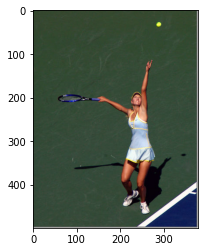

In [26]:
import matplotlib.pyplot as plt

plt.imshow(img)